# 08 - Hierarchical Models (latent mixture model)

Note: The following example is based on chapters 6.1 and 6.2 of [BCM] from the literature list of this course. Some code parts are adapted by https://github.com/pymc-devs/resources/blob/master/BCM/ParameterEstimation/Latent-mixtureModels.ipynb.

15 students wrote a test consisting of a total of 40 true or false questions. Each correct answer was worth a point and the results of the 15 students can be seen in the following list:

In [2]:
k = [21, 17, 21, 18, 22, 31, 31, 34, 34, 35, 35, 36, 39, 36, 35]
k = sorted(k)

We could visualize this as follows:

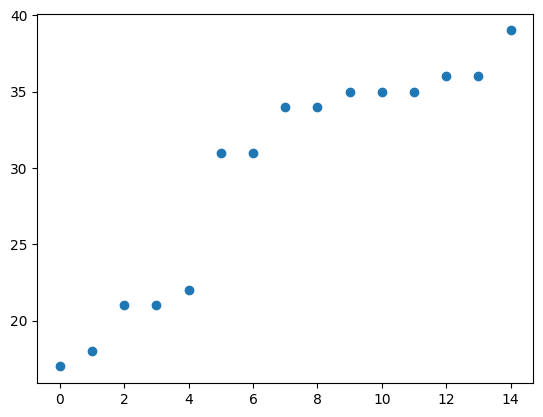

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k, 'o')

We can clearly identify two groups. Apparently, one group of 10 people was studying and preparing for the test, but 5 were poorly prepared or even just guessed. We now want to model this behavior and make inferences about group membership, and the success rate of the knowledge group.

The group of bad students probably had to guess at questions in this test because they were not prepared. Their probability to answer a question correctly can be expressed by $\psi = 0.5$.

The group of good students did not have to guess, their probability for a correct answer is over 50%, but depends on how well they prepared. We model this via an uniform distribution in the interval [0.5,1.0] and call this $\phi \sim \text{U}(0.5,1)$.

Given these two probabilities, the number of correct answers $k$ is then again binomially distributed with parameter $n=40$.

To decide which of the two probabilities we assume for a student we can use a Bernoulli distribution. So we say that the class membership $z$ of a student is $z \sim \text{Bernoulli}(0.5)$ distributed.

Via this class affiliation $z$ we can now also model and obtain the probability for the binomial distribution in general:

$$ \theta = \begin{cases}
    \phi & \text{if } z  =  1 \\
    \psi & \text{if } z  =  0
  \end{cases} ~~ \text{ and } ~~ k \sim \text{Binomial}(\theta,n) $$
  
So we have defined all components per student that we need to model the whole thing. Now we just have to make sure that we also have to iterate over all 15 subjects!

___________________________

#### a) Simple latent mixture model

Draw the graphical model for the described implementation. Think of the box to iterate over several test persons. 
Then compare your model with the one in chapter 6.1 in [BCM].

_________________________

Now the realization in pymc:

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [phi]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.
/home/dominik/venvs/statmod/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Grouping <xarray.DataArray 'zi' (draw: 10000, zi_dim_0: 15)>
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
    chain     int64 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * zi_dim_0  (zi_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14


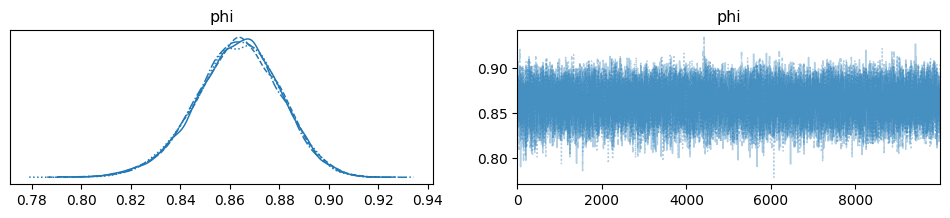

In [37]:
import pytensor.tensor as pt
import pymc as pm
import arviz as az

n = 40 # number of questions

with pm.Model() as latent_mixture_model:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=len(k))
    # accuracy prior
    phi = pm.Uniform('phi', upper=1, lower=.5)
    psi = .5
    # using pytensor tensors to describe cases
    theta = pm.Deterministic('theta', pt.switch(pt.eq(zi, 1), phi, psi))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    
    trace_lmm = pm.sample(10000)

az.plot_trace(trace_lmm, ['phi']);

ztrace = trace_lmm.posterior['zi']
print('Grouping', ztrace[-1, :])

In [38]:
with latent_mixture_model:
    postpred_lmm = pm.sample_posterior_predictive(trace_lmm, var_names=["ki"])

Sampling: [ki]


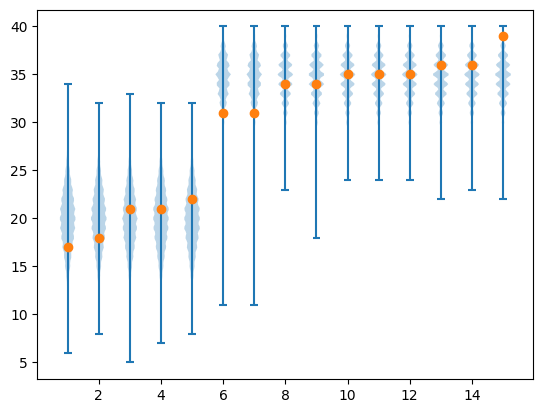

In [39]:
plt.violinplot(postpred_lmm.posterior_predictive["ki"].stack(samples=("chain", "draw")).T)
plt.plot(np.arange(1, 16), k, 'o')

This kind of model is called __latent mixture model__, because the data are
assumed to be generated by two different processes that combine or mix, and important
properties of that mixture are unobserved or latent.

#### b) Individual differences model

Our previous model already works quite well, but has a major conceptual weakness. We have used the assumption that every good student has the same probability to answer a question correctly. You probably know from your own experience that this is not true. So we have to think about how we can give each student an individual probability of success.

To do this, we use a $\phi$ per student (a vector with shape 15) instead of a shared $\phi$ for all students.

In [40]:
with pm.Model() as individual_differences_model:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=15)
    # accuracy prior
    psi = .5
    phi = pm.Uniform('phi', upper=1, lower=0.5, shape=15)
    
    theta = pm.Deterministic('theta', pt.switch(pt.eq(zi, 1), phi, psi))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)

    trace_id = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [phi]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 29 seconds.
/home/dominik/venvs/statmod/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

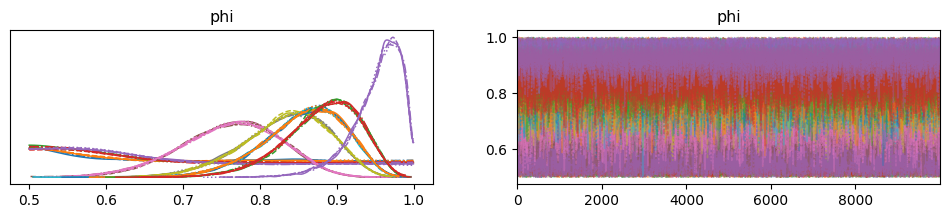

In [41]:
az.plot_trace(trace_id, ['phi'])

In [42]:
with individual_differences_model:
    postpred_id = pm.sample_posterior_predictive(trace_id, var_names=["ki"])
    

Sampling: [ki]


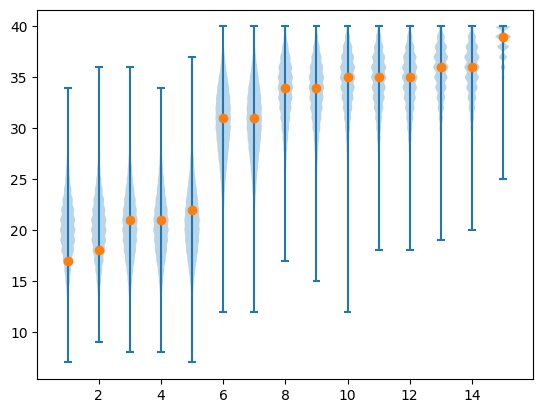

In [44]:
plt.violinplot(postpred_id.posterior_predictive["ki"].stack(samples=("chain", "draw")).T)
plt.plot(np.arange(1, 16), k, 'o')

#### c) Hierarchical model


Now, we use a so-called __hierarchical model__. The idea here is that we draw the probability $\phi$ itself from a distribution. So you build a new level into the model to describe the parameter.

For example, we could say that the success rate for each student comes from a Gaussian distribution. In this way you can map individual differences. The parameters of this Gaussian distribution are called __hyperparameters__.

In this case, we assume a Gaussian distribution $\phi \sim \mathcal(\mu,\lambda)$ whose mean value we draw equally distributed $\mu \sim U(0.5,1)$ and whose standard deviation we keep as flat as possible (so a bigger precision) and thus select as $\lambda \sim \text{Gamma}(0.001,0.001)$.
___________________________

Draw the graphical model for the described hierarchical implementation (you can extend your model from Task 4). 
Then compare your model with the one in chapter 6.2 in [BCM].

_________________________

Now the realization in pymc3:

In [47]:
with pm.Model() as hierarchical_model:
    # group prior
    zi = pm.Bernoulli('zi', p=.5, shape=15)
    # accuracy prior
    psi = .5
    
    # hyperprior
    mu = pm.Uniform('mu', upper=1, lower=.5)
    lambda_ = pm.Gamma('lambda_', alpha=.001, beta=.001)
    
    phi = pm.Truncated('phi', pm.Normal.dist(mu=mu, tau=lambda_), shape=15, lower=0, upper=1)
    
    theta = pm.Deterministic('theta', pt.switch(pt.eq(zi, 1), phi, psi))
    
    # observed
    ki = pm.Binomial('ki', p=theta, n=n, observed=k)
    
    trace_hm = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [zi]
>NUTS: [mu, lambda_, phi]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 67 seconds.
/home/dominik/venvs/statmod/lib/python3.8/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 1112 divergences after tuning. Increase `target_accept` or reparameterize.


Grouping <xarray.DataArray 'zi' (draw: 10000, zi_dim_0: 15)>
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])
Coordinates:
    chain     int64 3
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * zi_dim_0  (zi_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14


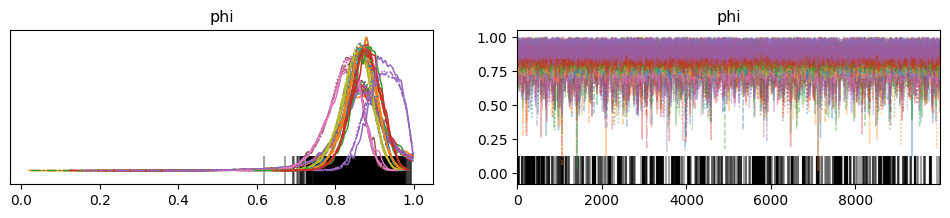

In [48]:
az.plot_trace(trace_hm, ['phi']);


ztrace = trace_hm.posterior['zi'][:]
print('Grouping', ztrace[-1, :])

In [33]:
with hierarchical_model:
    postpred_hm = pm.sample_posterior_predictive(trace_hm, var_names=["ki"]) 

Sampling: [ki]


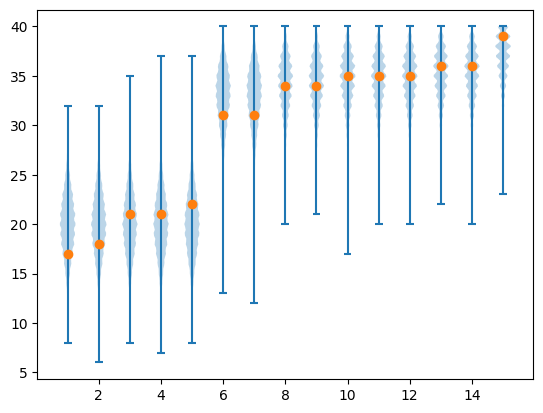

In [34]:
plt.violinplot(postpred_hm.posterior_predictive["ki"].stack(samples=("chain", "draw")).T)
plt.plot(np.arange(1, 16), k, 'o')

We can also visualize the samples of $\theta$ as boxplots:

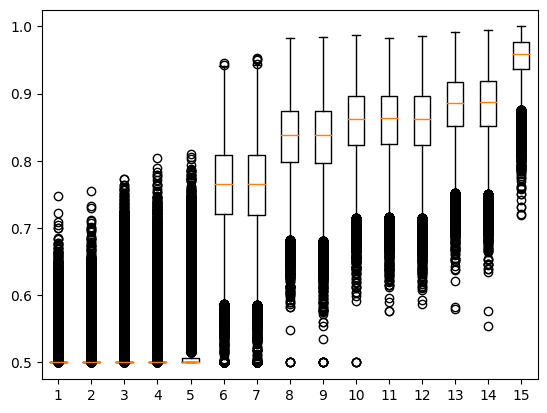

In [26]:
plt.figure()
thetapost = trace_hm.posterior['theta'].stack(samples=("chain", "draw")).T
plt.boxplot(thetapost)
plt.show()